# **Image Segmentation using PyTorch**
**PROJECT DESCRIPTION**

- Understand the Segmentation Dataset and write a custom dataset class for Image-Mask dataset. Additionally, apply segmentation augmentation to augment images as well as its masks.
- For image-mask augmentation you will use ***albumentation library*** and plot the image-Mask pair.
- Load a pretrained state of the art convolutional neural network for segmentation problem (e.g, U-net) using segmentation model PyTorch library.
- Create train function and evaluator function which will helpful to write training loop. Moreover, use training loop to train the model.


In [ ]:
!wget -c https://raw.githubusercontent.com/udacity/deep-learning-v2-pytorch/master/intro-to-pytorch/helper.py

--2023-08-15 16:00:17--  https://raw.githubusercontent.com/udacity/deep-learning-v2-pytorch/master/intro-to-pytorch/helper.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2813 (2.7K) [text/plain]
Saving to: ‘helper.py’

helper.py           100%[===================>]   2.75K  --.-KB/s    in 0s      

2023-08-15 16:00:17 (45.8 MB/s) - ‘helper.py’ saved [2813/2813]



**1. Install packages**

In [ ]:
# Install libraries we need
!pip install segmentation-models-pytorch
!pip install -U git+https://github.com/albumentations-team/albumentations

  Cloning https://github.com/albumentations-team/albumentations to /tmp/pip-req-build-jl0gsap5
  Running command git clone --filter=blob:none --quiet https://github.com/albumentations-team/albumentations /tmp/pip-req-build-jl0gsap5
  Resolved https://github.com/albumentations-team/albumentations to commit e3b47b3a127f92541cfeb16abbb44a6f8bf79cc8
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 MB 10.6 MB/s eta 0:00:00


In [ ]:
!pip uninstall opencv-python-headless==4.5.5.62
!pip install opencv-python-headless==4.5.2.52

**2. Download dataset**

In [ ]:
!git clone https://github.com/parth1620/Human-Segmentation-Dataset-master.git

Cloning into 'Human-Segmentation-Dataset-master'...
remote: Enumerating objects: 592, done.
remote: Counting objects: 100% (592/592), done.
remote: Compressing objects: 100% (591/591), done.
remote: Total 592 (delta 3), reused 587 (delta 1), pack-reused 0
Receiving objects: 100% (592/592), 13.60 MiB | 34.05 MiB/s, done.
Resolving deltas: 100% (3/3), done.


In [ ]:
# Import libraries
import sys
sys.path.append('/content/Human-Segmentation-Dataset-master')

**3. Import libraries**

In [ ]:
import torch
import cv2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import helper

**4. Set up configuration**

In [ ]:
CSV_FILE = '/content/Human-Segmentation-Dataset-master/train.csv'
DATA_DIR = '/content/'

DEVICE = 'cuda'
EPOCHS = 25
BATCH_SIZE = 16
LR = 0.003
IMG_SIZE = 320
ENCODER = 'timm-efficientnet-b0'
WEIGHTS = 'imagenet'

In [ ]:
df = pd.read_csv(CSV_FILE)
df.head(10)

,masks,images
0,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
1,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
2,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
3,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
4,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
5,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
6,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
7,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
8,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
9,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...


**5. Image Processing**

In [ ]:
row = df.iloc[2]
img_path = row.images
mask_path = row.masks

img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE) / 255.

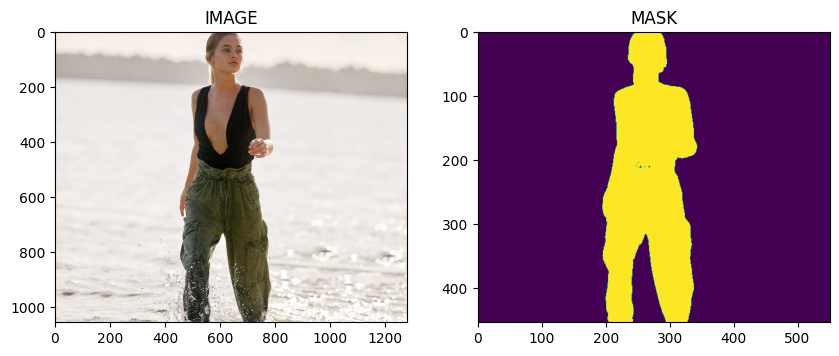

In [ ]:
# Look at a Image-Mask pair
f, (ax1, ax2) = plt.subplots(1,2,figsize=(10,5))

ax1.set_title('IMAGE')
ax1.imshow(img)
ax2.set_title('MASK')
ax2.imshow(mask)

**6. Split Train - Validation dataset**

In [ ]:
# Split dataset
train_df, val_df = train_test_split(df, test_size=0.2,random_state=42)

**7. Data Augmentation using albumentation library**

In [ ]:
# Data Augmentation using albumentation library
import albumentations as A

def train_augmentation():
  return A.Compose([A.Resize(IMG_SIZE,IMG_SIZE),
                    A.HorizontalFlip(p=0.5),
                    A.VerticalFlip(p=0.5)],
                   is_check_shapes=False)

def val_augmentation():
  return A.Compose([A.Resize(IMG_SIZE,IMG_SIZE)],
                   is_check_shapes=False)

**8. Create custom dataset**

In [ ]:
from torch.utils.data import Dataset

In [ ]:
class SegmentationDataset(Dataset):
  def __init__(self, df, augmentations):
    self.df = df
    self.augmentations = augmentations

  def __len__(self):
    return len(self.df)

  def __getitem__(self,idx):
    row = self.df.iloc[idx]
    img_path = row.images
    mask_path = row.masks

    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE) # (h,w,c)
    mask = np.expand_dims(mask, axis = -1)

    if self.augmentations:
      data = self.augmentations(image = img, mask = mask)
      img = data['image']
      mask = data['mask']

      #(h,w,c) --> (c,h,w)
      img = np.transpose(img,(2,0,1)).astype(np.float32)
      mask = np.transpose(mask,(2,0,1)).astype(np.float32)
      # convert np array to tensor
      img = torch.Tensor(img)/255.
      mask = torch.round(torch.Tensor(mask)/255.)

      return img, mask

In [ ]:
# Create train and validation set
train_set = SegmentationDataset(train_df,train_augmentation())
valid_set = SegmentationDataset(val_df,val_augmentation())

In [ ]:
print(f'Size of training set:{len(train_set)}')
print(f'Size of validation set:{len(valid_set)}')

Size of training set:232
Size of validation set:58


<Axes: >

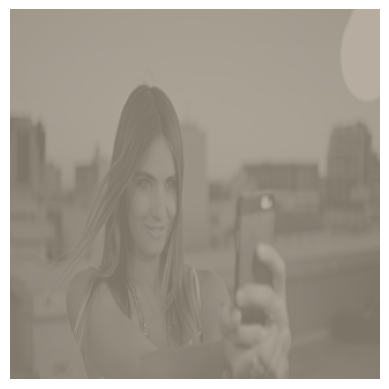

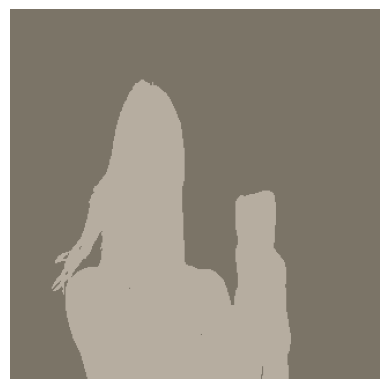

In [ ]:
# Show a img-mask pair in train_set
idx = 16
img, mask = train_set[idx]
helper.imshow(img[0].view(1,320, 320))
helper.imshow(mask[0].view(1,320, 320))

In [ ]:
# Load dataset into batches
from torch.utils.data import DataLoader

In [ ]:
train_load = DataLoader(train_set,batch_size=BATCH_SIZE,shuffle=True)
val_load = DataLoader(valid_set,batch_size=BATCH_SIZE)

In [ ]:
print(f'Total no. of batches in train loader:{len(train_load)}')
print(f'Total no. of batches in val loader:{len(val_load)}')

Total no. of batches in train loader:15
Total no. of batches in val loader:4


In [ ]:
for img, mask in train_load:
  break

print(f'One batch img shape:{img.shape}')
print(f'One batch mask shape:{mask.shape}')

One batch img shape:torch.Size([16, 3, 320, 320])
One batch mask shape:torch.Size([16, 1, 320, 320])


**9. Model**

In [ ]:
# Define Segmentation model
from torch import nn
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss

In [ ]:
class SegmentationModel(nn.Module):
  def __init__(self):
    super(SegmentationModel, self).__init__()

    self.arc = smp.Unet(
        encoder_name = ENCODER,
        encoder_weights = WEIGHTS,
        in_channels = 3,
        classes = 1,
        activation = None
    )
  def forward(self, images, masks=None):
    logits = self.arc(images)
    if masks != None:
      loss_1 = DiceLoss(mode = 'binary')(logits, masks)
      loss_2 = nn.BCEWithLogitsLoss()(logits, masks)
      return logits, loss_1 + loss_2

    return logits

In [ ]:
model = SegmentationModel()
model.to(DEVICE)

SegmentationModel(
  (arc): Unet(
    (encoder): EfficientNetEncoder(
      (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn1): BatchNormAct2d(
        32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
        (drop): Identity()
        (act): Swish()
      )
      (blocks): Sequential(
        (0): Sequential(
          (0): DepthwiseSeparableConv(
            (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (bn1): BatchNormAct2d(
              32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
              (drop): Identity()
              (act): Swish()
            )
            (se): SqueezeExcite(
              (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
              (act1): Swish()
              (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
              (gate): Sigmoid()
            )
           

In [ ]:
# Create train and evaluation function
def train_fn(data_loader, model, optimizer):

  model.train()
  total_loss = 0.0

  for images, masks in tqdm(data_loader):
    images = images.to(DEVICE)
    masks = masks.to(DEVICE)
    optimizer.zero_grad()
    logits, loss = model(images,masks)
    loss.backward()
    optimizer.step()
    total_loss += loss.item()

  return total_loss / len(data_loader)

In [ ]:
def evaluate_fn(data_loader, model):

  model.eval()
  total_loss = 0.0

  with torch.no_grad():
    for images, masks in tqdm(data_loader):

      images = images.to(DEVICE)
      masks = masks.to(DEVICE)

      logits, loss = model(images,masks)

      total_loss += loss.item()

  return total_loss / len(data_loader)

In [ ]:
# Train model
optimizer = torch.optim.Adam(model.parameters(), lr = LR)

In [ ]:
best_val_loss = np.Inf

for i in range(EPOCHS):
  train_loss = train_fn(train_load, model, optimizer)
  val_loss = evaluate_fn(val_load, model)

  if val_loss < best_val_loss:
    torch.save(model.state_dict(),'best_model.pt')
    print("Save model")
    best_val_loss = val_loss

  print(f"Epoch:{i+1} => Train_loss = {train_loss} - Valid_loss = {val_loss}")


100%|██████████| 4/4 [00:01<00:00,  3.64it/s]


Save model
Epoch:1 => Train_loss = 0.7849622527758281 - Valid_loss = 0.7750782072544098


100%|██████████| 4/4 [00:00<00:00,  5.02it/s]


Save model
Epoch:2 => Train_loss = 0.4078177909056346 - Valid_loss = 0.40111349523067474


100%|██████████| 4/4 [00:00<00:00,  5.15it/s]


Epoch:3 => Train_loss = 0.2835526277621587 - Valid_loss = 0.5959837809205055


100%|██████████| 4/4 [00:00<00:00,  5.11it/s]


Save model
Epoch:4 => Train_loss = 0.3036313712596893 - Valid_loss = 0.2720798924565315


100%|██████████| 4/4 [00:00<00:00,  4.96it/s]


Epoch:5 => Train_loss = 0.27300808231035867 - Valid_loss = 0.30402277410030365


100%|██████████| 4/4 [00:01<00:00,  3.80it/s]


Save model
Epoch:6 => Train_loss = 0.2515107810497284 - Valid_loss = 0.25495658442378044


100%|██████████| 4/4 [00:00<00:00,  5.12it/s]


Save model
Epoch:7 => Train_loss = 0.22245459159215292 - Valid_loss = 0.19853901118040085


100%|██████████| 4/4 [00:00<00:00,  5.11it/s]


Epoch:8 => Train_loss = 0.19819462398687998 - Valid_loss = 0.210516519844532


100%|██████████| 4/4 [00:01<00:00,  3.14it/s]


Epoch:9 => Train_loss = 0.17123658855756124 - Valid_loss = 0.21816258877515793


100%|██████████| 4/4 [00:00<00:00,  5.05it/s]


Save model
Epoch:10 => Train_loss = 0.1436946878830592 - Valid_loss = 0.18299930915236473


100%|██████████| 4/4 [00:01<00:00,  3.71it/s]


Epoch:11 => Train_loss = 0.1341721793015798 - Valid_loss = 0.2493044063448906


100%|██████████| 4/4 [00:00<00:00,  4.61it/s]


Epoch:12 => Train_loss = 0.14377222061157227 - Valid_loss = 0.22045670822262764


100%|██████████| 4/4 [00:00<00:00,  4.97it/s]


Epoch:13 => Train_loss = 0.1670206258694331 - Valid_loss = 0.32837506011128426


100%|██████████| 4/4 [00:00<00:00,  5.02it/s]


Epoch:14 => Train_loss = 0.16067096143960952 - Valid_loss = 0.21231849491596222


100%|██████████| 4/4 [00:00<00:00,  5.13it/s]


Epoch:15 => Train_loss = 0.1747721071044604 - Valid_loss = 0.2120669223368168


100%|██████████| 4/4 [00:01<00:00,  3.82it/s]


Epoch:16 => Train_loss = 0.14502659042676289 - Valid_loss = 0.2133539356291294


100%|██████████| 4/4 [00:00<00:00,  5.02it/s]


Epoch:17 => Train_loss = 0.13538469076156617 - Valid_loss = 0.2153128869831562


100%|██████████| 4/4 [00:00<00:00,  4.99it/s]


Epoch:18 => Train_loss = 0.1458807994922002 - Valid_loss = 0.21122369170188904


100%|██████████| 4/4 [00:00<00:00,  4.99it/s]


Epoch:19 => Train_loss = 0.12079609582821528 - Valid_loss = 0.25483253598213196


100%|██████████| 4/4 [00:00<00:00,  5.04it/s]


Epoch:20 => Train_loss = 0.11231444428364436 - Valid_loss = 0.225993774831295


100%|██████████| 4/4 [00:01<00:00,  3.87it/s]


Epoch:21 => Train_loss = 0.09107774843772252 - Valid_loss = 0.22653796896338463


100%|██████████| 4/4 [00:00<00:00,  5.02it/s]


Epoch:22 => Train_loss = 0.09879311745365461 - Valid_loss = 0.22185256704688072


100%|██████████| 4/4 [00:00<00:00,  4.99it/s]


Save model
Epoch:23 => Train_loss = 0.10832613110542297 - Valid_loss = 0.17726672440767288


100%|██████████| 4/4 [00:00<00:00,  4.46it/s]


Epoch:24 => Train_loss = 0.10344499895970026 - Valid_loss = 0.23095455020666122


100%|██████████| 4/4 [00:00<00:00,  4.98it/s]

Epoch:25 => Train_loss = 0.11249351898829142 - Valid_loss = 0.18782412260770798


**10. Predictions**

In [ ]:
# Load model
model.load_state_dict(torch.load('/content/best_model.pt'))

# Load a img-mask pair in validation set
idx = 12
img, mask = valid_set[idx]
logits_mask = model(img.to(DEVICE).unsqueeze(0)) # add batch dimension (C,H,W) => (1,C,H,W)
pred_mask = torch.sigmoid(logits_mask) # output value from 0-1 to predict
pred_mask = (pred_mask > 0.5)*1.0


Image-Mask pair in validation set


<Axes: >

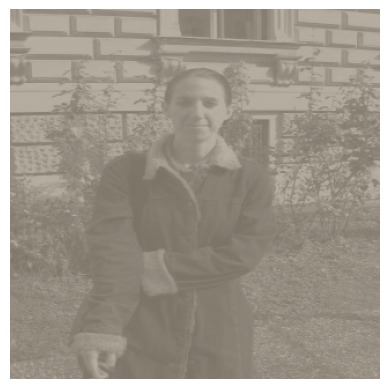

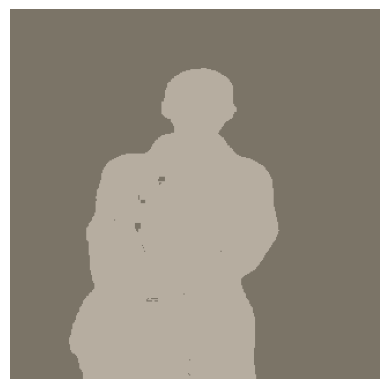

In [ ]:
# helper.imshow(img, mask, pred_mask.detach().cpu().squeeze(0))
print("Image-Mask pair in validation set")
helper.imshow(img[0].view(1,320,320))
helper.imshow(mask[0].view(1,320,320))

Mask prediction


<Axes: >

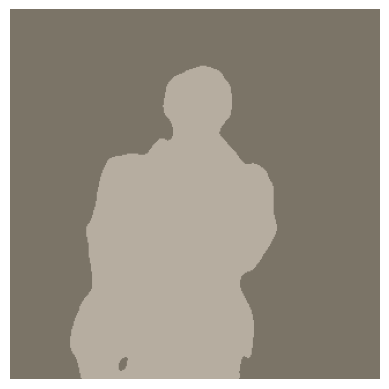

In [ ]:
# Show mask prediction of img
print("Prediction")
pred_mask = pred_mask.detach().cpu().squeeze(0)
helper.imshow(pred_mask[0].view(1,320,320))

In [ ]:
# Test on my image
my_img = cv2.imread('/content/026.jpg')
my_img = cv2.resize(my_img,(IMG_SIZE,IMG_SIZE))
# my_img = cv2.cvtColor(my_img, cv2.COLOR_BGR2RGB)

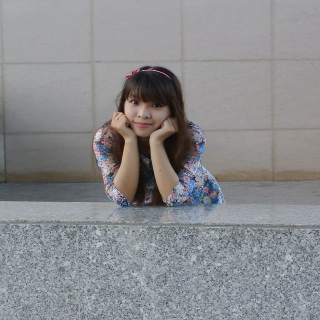

In [ ]:
from google.colab.patches import cv2_imshow
cv2_imshow(my_img)

In [ ]:
new_img = np.transpose(my_img,(2,0,1)).astype(np.float32)
# convert my_img to tensor
new_img = torch.Tensor(new_img)/255.

In [ ]:
logits_mask = model(new_img.to(DEVICE).unsqueeze(0))

In [ ]:
pred_mask = torch.sigmoid(logits_mask) # output value from 0-1 to predict
pred_mask = (pred_mask > 0.5)*1.0

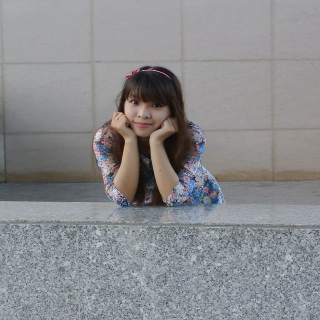

In [ ]:
cv2_imshow(my_img)

Prediction


<Axes: >

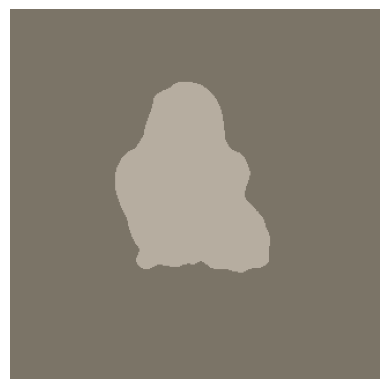

In [ ]:
print("Prediction")
pred_mask = pred_mask.detach().cpu().squeeze(0)
helper.imshow(pred_mask[0].view(1,320,320))